### Objective
To investigate the trend and pattern of time seriese data (UNSTA Weather Data) using the Long Short Term Memory (LSTM) networks and quantify the uncertianty of the time series prediction of target variables.

### Tasks and Ideas
- Try to add hour of the day as a predictor

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import tqdm
import random
import os

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K

### Importing dataset

The dataset consists in a series of measurements made at the meteorological station at the University.


In [2]:
dataset = pd.read_csv('./../01 - Data Preprocessing/Data/dataset_by_hour.csv', index_col='Datetime')
dataset = dataset[['Temp_Out', 'Out_Hum', 'Dew_Pt', 'Wind_Speed',
                  'Wind_Chill', 'Rain_Rate', 'Heat_Index', 'Barometer', 'Solar_Rad',
                  'UV_Index']]
dataset.head()

,Temp_Out,Out_Hum,Dew_Pt,Wind_Speed,Wind_Chill,Rain_Rate,Heat_Index,Barometer,Solar_Rad,UV_Index
Datetime,,,,,,,,,,
2019-03-26 15:00:00,15.0,0.920000,14.377778,1.244444,15.688889,0.0,15.933333,959.622222,116.111111,0.944444
2019-03-26 16:00:00,15.0,0.910000,14.108333,1.466667,15.608333,0.0,15.808333,959.250000,114.583333,0.833333
2019-03-26 17:00:00,15.0,0.906667,14.075000,1.066667,15.616667,0.0,15.808333,958.966667,57.250000,0.266667
2019-03-26 18:00:00,15.0,0.919167,13.983333,0.400000,15.300000,0.0,15.550000,959.158333,11.000000,0.000000
2019-03-26 19:00:00,15.0,0.924167,13.958333,1.333333,15.200000,0.0,15.400000,959.691667,0.833333,0.000000


In [3]:
dataset['Month'] = pd.to_datetime(dataset.index.values)
dataset['Month'] = dataset['Month'].apply(lambda x: x.month)
dataset_with_dummies = dataset.join(pd.get_dummies(dataset['Month'], prefix="Month"))
dataset_with_dummies.drop('Month', axis=1,inplace=True)

In [4]:
for col in dataset_with_dummies.columns:
    dataset_with_dummies[col] = dataset_with_dummies[col].astype(np.float32)

In [5]:
dataset_with_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10377 entries, 2019-03-26 15:00:00 to 2020-05-31 23:00:00
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Temp_Out    10377 non-null  float32
 1   Out_Hum     10377 non-null  float32
 2   Dew_Pt      10377 non-null  float32
 3   Wind_Speed  10377 non-null  float32
 4   Wind_Chill  10377 non-null  float32
 5   Rain_Rate   10377 non-null  float32
 6   Heat_Index  10377 non-null  float32
 7   Barometer   10377 non-null  float32
 8   Solar_Rad   10377 non-null  float32
 9   UV_Index    10377 non-null  float32
 10  Month_1     10377 non-null  float32
 11  Month_2     10377 non-null  float32
 12  Month_3     10377 non-null  float32
 13  Month_4     10377 non-null  float32
 14  Month_5     10377 non-null  float32
 15  Month_6     10377 non-null  float32
 16  Month_7     10377 non-null  float32
 17  Month_8     10377 non-null  float32
 18  Month_9     10377 non-null  float32
 19

In [6]:
scaler = MinMaxScaler()

### Functions Definitions

In [7]:
def scale_data(data):
    data.iloc[:,1:] = scaler.fit_transform(data.iloc[:,1:])
    return data

# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[:9000], data[9000:10370]
    # restructure into windows of weekly data
    train = np.array(np.split(train, len(train)/5))
    test = np.array(np.split(test, len(test)/5))
    return train, test

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end < len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return np.array(X), np.array(y)

def build_model_lstm(train, n_input, n_output, epochs, batch_size):
    # prepare data
    X_train, y_train = to_supervised(train, n_input, n_output)
    X_test, y_test = to_supervised(test, n_input, n_output)
    
    # define parameters
    verbose = 1
    
    n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], X_train.shape[1]
    # reshape output into [samples, timesteps, features]
    
    y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
    
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    
    # fit network
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split= 0.1)
    
    plt.figure()
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['loss'])
    plt.show()
    
    return X_test, y_test, model, history.history

# # make a forecast
# def forecast(model, history, n_input):
#     # flatten data
#     data = np.array(history)
#     data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
#     # retrieve last observations for input data
#     input_x = data[-n_input:, :]
#     # reshape into [1, n_input, n]
#     input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
#     # forecast the next week
#     yhat = model.predict(input_x, verbose=0)
#     # we only want the vector forecast
#     yhat = yhat[0]
#     return yhat

### Dataset Preparation for Modelling

In [8]:
dataset_scaled = scale_data(dataset_with_dummies)
train, test = split_dataset(dataset_scaled.values)

### Model 1 - Deterministic LSTM

#### 1.1 Fitting model

In [9]:
train.shape

(1800, 5, 22)

Epoch 1/100
127/127 [==============================] - 10s 81ms/step - loss: 28.9064 - val_loss: 11.3122
Epoch 2/100
127/127 [==============================] - 11s 89ms/step - loss: 10.8948 - val_loss: 14.5356
Epoch 3/100
127/127 [==============================] - 12s 91ms/step - loss: 9.7222 - val_loss: 6.2143
Epoch 4/100
127/127 [==============================] - 11s 90ms/step - loss: 8.8534 - val_loss: 9.3893
Epoch 5/100
127/127 [==============================] - 12s 91ms/step - loss: 8.4478 - val_loss: 7.6534
Epoch 6/100
127/127 [==============================] - 11s 87ms/step - loss: 7.8686 - val_loss: 8.1785
Epoch 7/100
127/127 [==============================] - 12s 95ms/step - loss: 7.8238 - val_loss: 10.1657
Epoch 8/100
127/127 [==============================] - 12s 97ms/step - loss: 7.3789 - val_loss: 6.8633
Epoch 9/100
127/127 [==============================] - 12s 97ms/step - loss: 6.9187 - val_loss: 5.4147
Epoch 10/100
127/127 [==============================] - 12s 98ms/ste

Epoch 80/100
127/127 [==============================] - 8s 64ms/step - loss: 1.7851 - val_loss: 5.6426
Epoch 81/100
127/127 [==============================] - 8s 63ms/step - loss: 1.8096 - val_loss: 5.4251
Epoch 82/100
127/127 [==============================] - 8s 62ms/step - loss: 1.9846 - val_loss: 5.9683
Epoch 83/100
127/127 [==============================] - 8s 61ms/step - loss: 1.7317 - val_loss: 5.8914
Epoch 84/100
127/127 [==============================] - 8s 60ms/step - loss: 1.5818 - val_loss: 5.7322
Epoch 85/100
127/127 [==============================] - 8s 61ms/step - loss: 1.5894 - val_loss: 6.2920
Epoch 86/100
127/127 [==============================] - 8s 62ms/step - loss: 1.5726 - val_loss: 5.7379
Epoch 87/100
127/127 [==============================] - 8s 61ms/step - loss: 1.6209 - val_loss: 6.6002
Epoch 88/100
127/127 [==============================] - 8s 61ms/step - loss: 1.4650 - val_loss: 7.2348
Epoch 89/100
127/127 [==============================] - 8s 61ms/step - lo

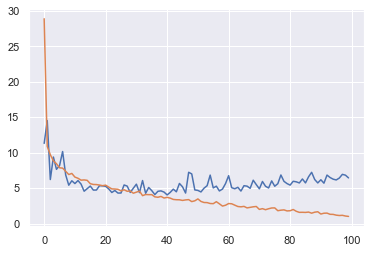

In [36]:
n_input = 12
n_output = 12
epochs = 100
batch_size = 64

# fit model
X_test, y_test, model, history = build_model_lstm(train, n_input, n_output, epochs, batch_size)

#### 1.2 Predicting and Plotting

In [ ]:
preds = list()
reals = list()

for i in range(len(X_test)):
    y_hat = model.predict(X_test[i].reshape(1,12,X_test.shape[2])).flatten()
    preds.append(y_hat[0])
    reals.append(y_test[i][0])

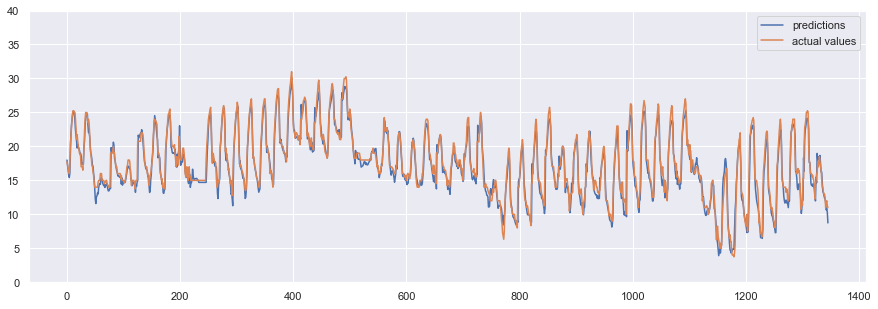

In [43]:
plt.figure(figsize=(15,5))
plt.plot(preds, label='predictions')
plt.plot(reals, label='actual values')
plt.legend(loc="upper right")
plt.ylim(0, 40)
plt.show()

### Model 2 - LSTM with Montecarlo Dropout - 12 steps

#### 2.1 Fitting model

In [10]:
n_input = 12
n_output = 12
epochs = 100
batch_size = 64

In [11]:
class MCDropout(Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

def build_model_lstm_mc(n_input, n_output, epochs, batch_size):
    
    X_train, y_train = to_supervised(train, n_input, n_output)
    X_test, y_test = to_supervised(test, n_input, n_output)

    # define parameters
    verbose = 1

    n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], X_train.shape[1]
    # reshape output into [samples, timesteps, features]

    y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))

    # define model
    model_mc = Sequential()
    model_mc.add(InputLayer(input_shape=(n_timesteps, n_features)))
    model_mc.add(MCDropout(0.5))
    model_mc.add(LSTM(200, activation="selu", kernel_initializer="lecun_normal", input_shape=(n_timesteps, n_features)))
    model_mc.add(MCDropout(0.3))
    model_mc.add(RepeatVector(n_outputs))
    model_mc.add(LSTM(200, activation="selu", kernel_initializer="lecun_normal", return_sequences=True))
    model_mc.add(MCDropout(0.2))
    model_mc.add(TimeDistributed(Dense(100, activation='selu')))
    model_mc.add(TimeDistributed(Dense(1)))
    # model_mc.add(Dense(1, activation=None))

    model_mc.compile(loss='mse', optimizer='adam')
    
#     fit network
    history_mc = model_mc.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split= 0.1)

#     plt.figure()
#     plt.plot(history_mc.history['val_loss'])
#     plt.plot(history_mc.history['loss'])
#     plt.show()
    
#     return X_test, y_test, model_mc, history_mc.history


Epoch 1/100
127/127 [==============================] - 4s 34ms/step - loss: 158.2235 - val_loss: 97.9338
Epoch 2/100
127/127 [==============================] - 4s 31ms/step - loss: 57.5436 - val_loss: 63.5204
Epoch 3/100
127/127 [==============================] - 5s 39ms/step - loss: 60.7467 - val_loss: 67.7176
Epoch 4/100
127/127 [==============================] - 6s 44ms/step - loss: 43.8776 - val_loss: 54.3927
Epoch 5/100
127/127 [==============================] - 6s 44ms/step - loss: 35.6281 - val_loss: 37.3704
Epoch 6/100
127/127 [==============================] - 6s 44ms/step - loss: 31.9413 - val_loss: 33.6486
Epoch 7/100
127/127 [==============================] - 6s 44ms/step - loss: 30.3479 - val_loss: 32.5909
Epoch 8/100
127/127 [==============================] - 6s 44ms/step - loss: 27.8758 - val_loss: 28.1034
Epoch 9/100
127/127 [==============================] - 6s 44ms/step - loss: 25.5561 - val_loss: 23.1864
Epoch 10/100
127/127 [==============================] - 6s 44ms

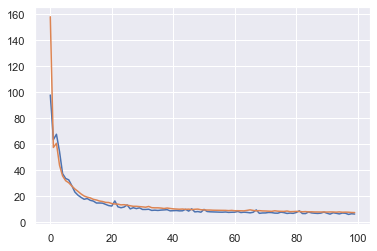

In [53]:
X_test_mc, y_test_mc, model_mc, history_mc = build_model_lstm_mc(n_input, n_output, epochs, batch_size)

In [ ]:
build_model_lstm_mc(n_input, n_output, epochs, batch_size)

- Try behavior changing activation function from selu to relu

#### 2.2 Predictions and Plotting entire validation set
- On each iteration, it will be predicted an entire week, but only plotted the first day of each searie

Let's see how predictions are made based on a single point. Which distribution does it has.

In [88]:
# for i in range(5):
#     day = i
#     pred_day = list()
#     for j in range(100):
#         y_hat = model_mc.predict(X_test[i].reshape(1,7,X_test.shape[2])).flatten()
#         pred_day.append(y_hat[0])
#     plt.figure()
#     sns.histplot(pred_day)
#     plt.axvline(y_test[i][0], color="red")
#     plt.show()

In [59]:
preds = list()

for i in range(len(X_test_mc)):
    day = i
    pred_day = list()
    for j in range(10):
        y_hat = model_mc.predict(X_test_mc[i].reshape(1,12,X_test_mc.shape[2])).flatten()
        pred_day.append(y_hat[0])
    preds.append([day] + pred_day + [y_test[i][0]])

preds = np.array(preds)

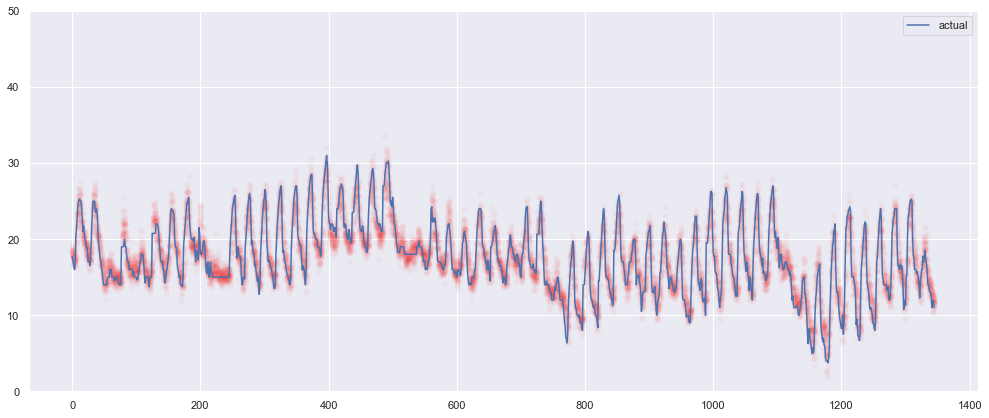

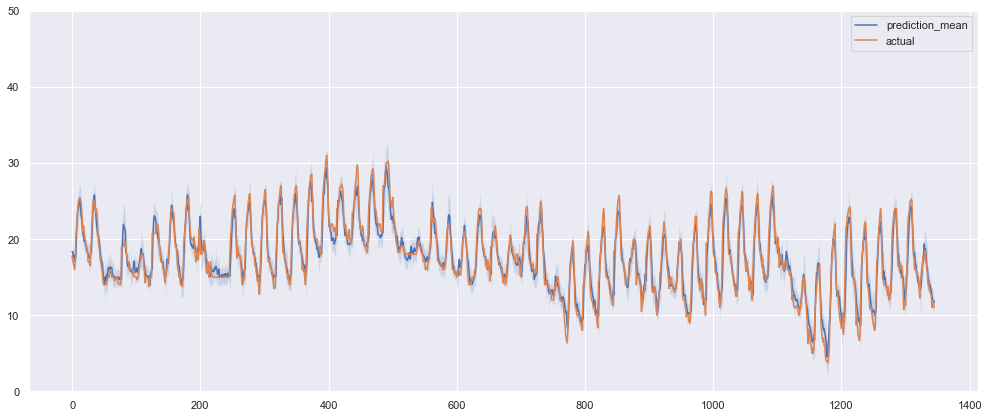

In [60]:
upper = [np.mean(row) + np.std(row)*2 for row in preds[:,1:-1]]
lower = [np.mean(row) - np.std(row)*2 for row in preds[:,1:-1]]
mean = [np.mean(row) for row in preds[:,1:-1]]


plt.figure(figsize=(17,7))
sns.lineplot(data=preds, x=preds[:,0],y=preds[:,-1], label="actual")

for i in range(preds.shape[1]-2):
    sns.scatterplot(data=preds, x=preds[:,0], y=preds[:,1+i], color="red", alpha=.03)
    
plt.ylim(0, 50)
plt.show()



plt.figure(figsize=(17,7))
sns.lineplot(data=preds, x=preds[:,0],y=mean, label="prediction_mean")
sns.lineplot(data=preds, x=preds[:,0],y=preds[:,-1], label="actual")

plt.fill_between(
    preds[:,0],
    upper,
    lower,
    alpha=0.2,
    label="95,4% confidence")

plt.ylim(0, 50)
plt.show()


#### 2.3 Predicting and plotting series of 7 days

In [63]:
def predict_one_day(day):
    rounds = 100
    preds_one_day = list()
    preds_day = list()

    for j in range(rounds):
        y_hat = model_mc.predict(X_test[day].reshape(1,12,X_test.shape[2])).flatten()
        preds_day.append(y_hat)

    preds_one_day = np.array(preds_day)

    one_day_df = pd.DataFrame(np.transpose(preds_one_day))
    one_day_df['actual'] = y_test[day]
    one_day_df['std'] = [np.std(row) for row in one_day_df.values[:,:-1]]
    one_day_df['mean'] = [np.mean(row) for row in one_day_df.values[:,:-2]]

    one_day_df['upper'] = one_day_df['mean'] + one_day_df['std']*2
    one_day_df['lower'] = one_day_df['mean'] - one_day_df['std']*2
    
    ax = plt.figure(figsize=(17,10))
    plt.yticks(np.arange(0, 40, step=1))

    sns.lineplot(
        data=one_day_df,
        x=one_day_df.index.values,
        y=one_day_df['actual'], label="actual")

    sns.lineplot(
        data=one_day_df,
        x=one_day_df.index.values,
        y=one_day_df['mean'], label="mean_predicted")


    plt.fill_between(
        one_day_df.index.values,
        one_day_df['upper'],
        one_day_df['lower'],
        alpha=0.3)

    for i in range(rounds-1):
        sns.scatterplot(
            data=one_day_df, 
            x=one_day_df.index.values,
            y=one_day_df.iloc[:,1+i], color="red", alpha=.05)
        
    plt.ylim(0,40)
    
    plt.show()

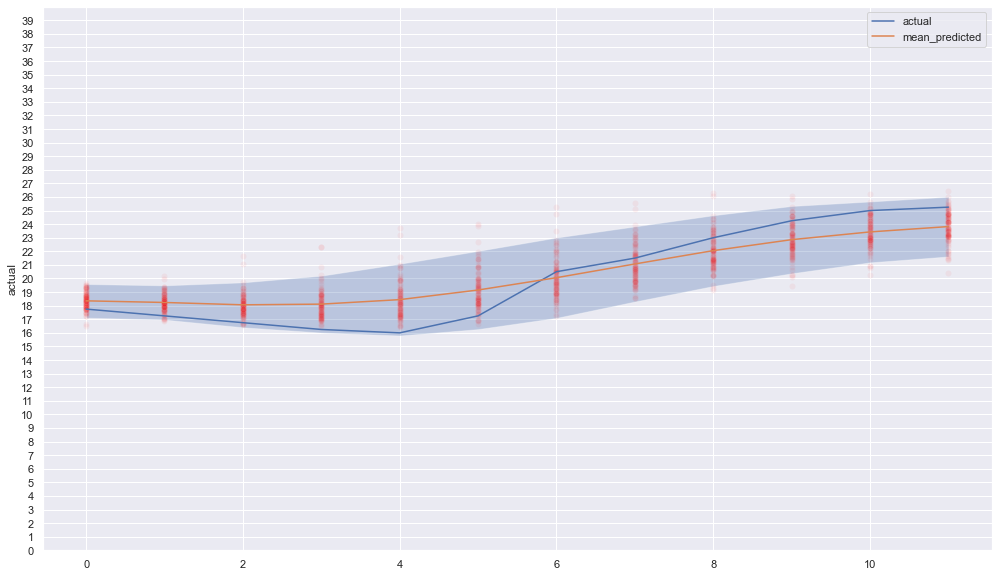

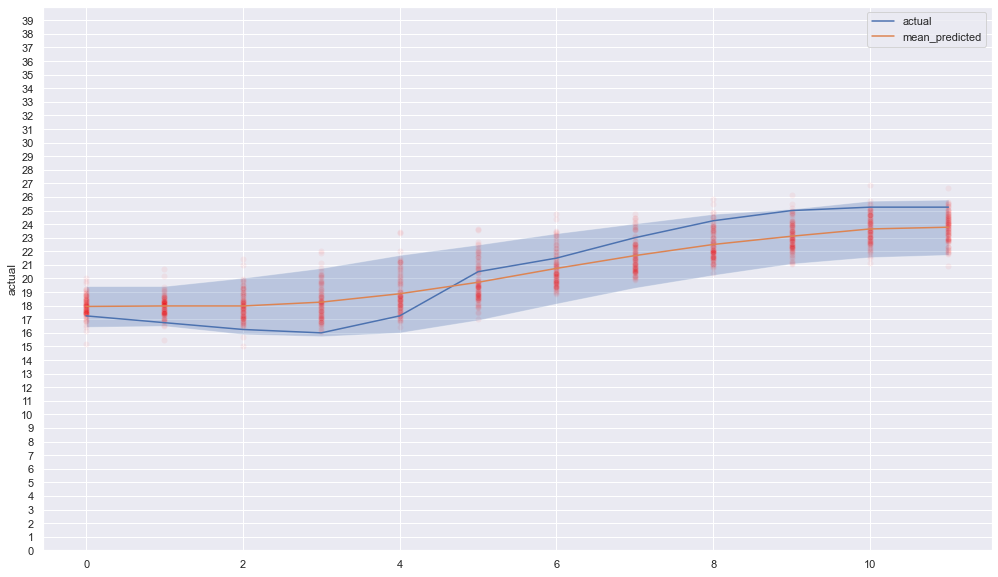

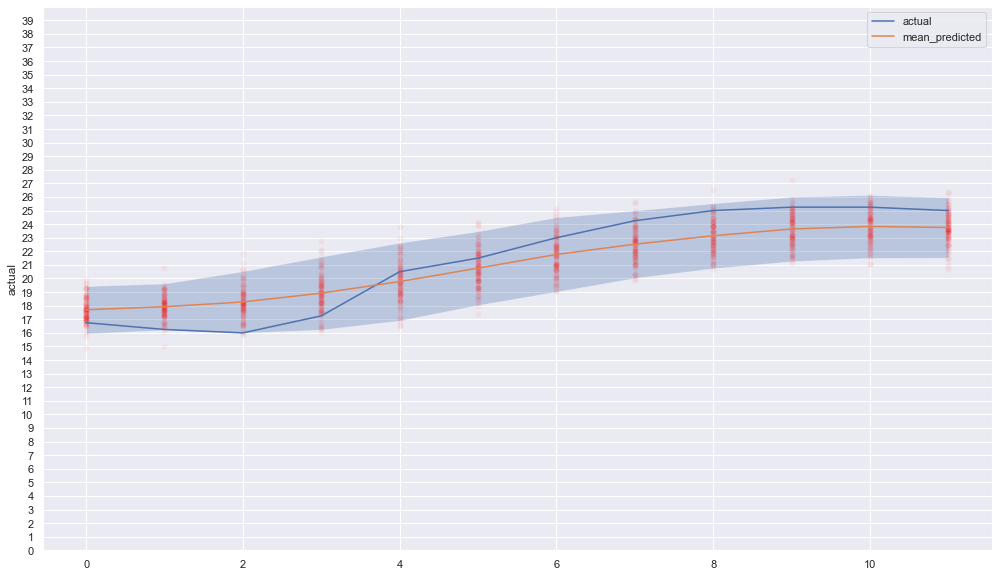

In [64]:
for i in range(3):
    predict_one_day(i)